In [12]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from S00_utils import plot_res, store_results


In [ ]:
df = pd.read_excel("output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__approximate_entropy__m_2__r_0.7,s1__autocorrelation__lag_9,s1__autocorrelation__lag_8,s1__autocorrelation__lag_7,s1__longest_strike_above_mean,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,...,"s1__agg_autocorrelation__f_agg_""mean""__maxlag_40",s1__ar_coefficient__coeff_10__k_10,"s1__fft_coefficient__attr_""abs""__coeff_4",s1__ar_coefficient__coeff_8__k_10,s1__approximate_entropy__m_2__r_0.5,"s1__fft_coefficient__attr_""abs""__coeff_3",s1__approximate_entropy__m_2__r_0.1,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,187.616451,1415.961916,2.557955,0.185766,-0.212687,-0.016548,0.180225,16,0.369965,0.545277,...,0.111814,0.275924,9.657168,-0.129524,0.281910,7.000403,0.130575,68.601545,1.058818,88.361693
E002,101.574829,1155.296145,1.610162,0.201643,-0.337147,-0.130801,0.081408,15,0.289928,0.485372,...,0.073067,0.295375,4.576206,-0.127716,0.287208,3.997053,0.138715,53.906180,0.928938,120.448962
E003,105.981660,1354.421797,1.471213,0.280074,-0.724746,-0.519171,-0.277401,12,-0.016292,0.245955,...,-0.103510,0.311143,0.164255,-0.115387,0.295983,0.149326,0.160892,46.590224,1.356625,87.797819
E004,183.202078,1143.123554,2.027678,0.181729,-0.174395,0.019032,0.211732,16,0.396457,0.566256,...,0.116791,-0.191406,10.139354,0.064453,0.286139,8.100158,0.120629,68.758466,0.840078,118.543881
E005,190.252994,1018.419233,2.150465,0.247459,-0.562449,-0.349593,-0.116660,13,0.122974,0.355548,...,-0.045042,0.286307,12.336134,-0.121797,0.293460,10.561980,0.144695,61.326411,0.925232,70.486440


In [14]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

X = df[colsX]
Y = df[colsY]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(Y_train.shape)

(70, 3)


In [15]:
scX = StandardScaler()
X_train_std = scX.fit_transform(X_train)
X_test_std = scX.transform(X_test)

scY = StandardScaler()
Y_train_std = scY.fit_transform(Y_train)
Y_test_std = scY.transform(Y_test)

In [16]:
from sklearn.base import BaseEstimator


class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator=None):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [17]:
# Need to append prefix to comply with param name in sklearn base class
def changeKey(s: dict):
    s_new = {}
    for k, v in s.items():
        if k != "estimator":
            s_new[f"estimator__estimator__{k}"] = v
        else:
            s_new[k] = v
    return s_new


svr = MultiOutputRegressor(estimator=SVR())
gbr = MultiOutputRegressor(estimator=GradientBoostingRegressor())

set1 = changeKey(dict(estimator=[svr], C=[0.1, 0.5, 1]))
set2 = changeKey(dict(estimator=[gbr], n_estimators=[1, 5, 10, 20]))

param_grid = [set1, set2]

In [18]:
gs = GridSearchCV(
    estimator=ClfSwitcher(),
    param_grid=param_grid,
    cv=2,
    n_jobs=-1,
)

In [19]:
gs.fit(X_train_std, Y_train_std)
Y_train_pred = gs.predict(X_train_std)
Y_test_pred = gs.predict(X_test_std)

In [20]:
df = pd.DataFrame(gs.cv_results_)
print(df.shape)
display(df.head())

(7, 13)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__estimator__C,param_estimator__estimator__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004253,0.000252,0.002756,2.521276e-04,MultiOutputRegressor(estimator=SVR()),0.1,NaN,{'estimator': MultiOutputRegressor(estimator=S...,0.305854,0.260444,0.283149,0.022705,6
1,0.004005,0.000997,0.001757,2.428293e-04,MultiOutputRegressor(estimator=SVR()),0.5,NaN,{'estimator': MultiOutputRegressor(estimator=S...,0.617706,0.661726,0.639716,0.022010,3
2,0.003500,0.000499,0.003256,2.566576e-04,MultiOutputRegressor(estimator=SVR()),1.0,NaN,{'estimator': MultiOutputRegressor(estimator=S...,0.734929,0.779820,0.757375,0.022446,2
3,0.008123,0.000745,0.001754,2.443790e-04,MultiOutputRegressor(estimator=GradientBoostin...,NaN,1.0,{'estimator': MultiOutputRegressor(estimator=G...,0.099113,0.107670,0.103392,0.004279,7
4,0.017539,0.000499,0.001999,9.536743e-07,MultiOutputRegressor(estimator=GradientBoostin...,NaN,5.0,{'estimator': MultiOutputRegressor(estimator=G...,0.428720,0.453830,0.441275,0.012555,5


,MSE Train,MSE Test,R2 Train,R2 Test
0,0.025383,0.094832,0.974617,0.889748
1,0.024610,0.060118,0.975390,0.918705
2,0.027643,0.100004,0.972357,0.884033


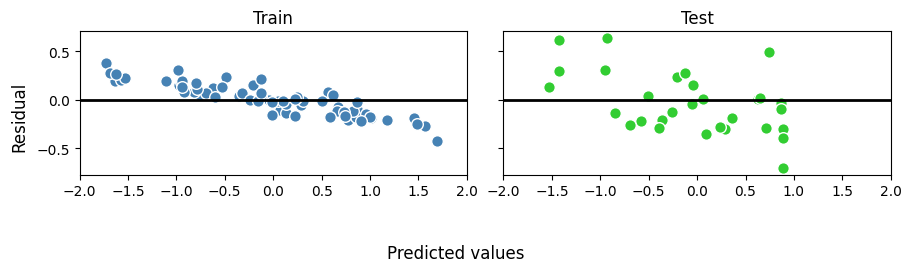

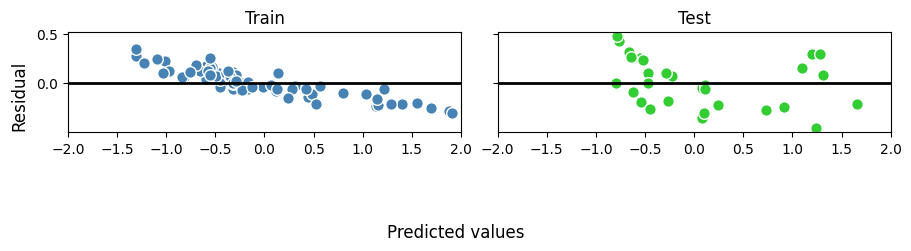

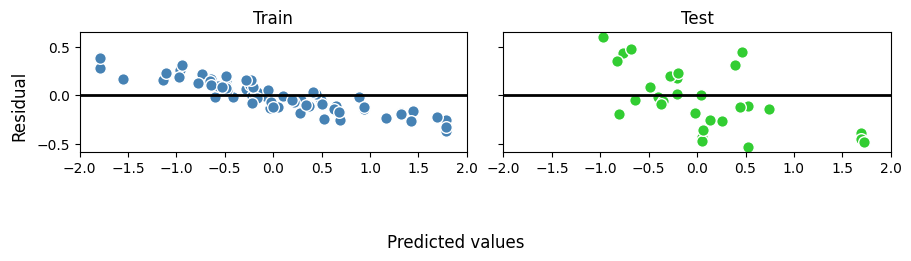

In [21]:
resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred)
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes
